<a href="https://colab.research.google.com/github/jairsilva0742/SignLanguageDetector/blob/main/Proyecto_Sign_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Proyecto de Detección de Letras - Lenguaje de Señas**
### **Integrantes**

*   Jair Silva Herrera - C.C. 1.030.375.674
*   Leonardo Castro Piracoa - C.C.


**Parte 1. Obtención de Datos**

---


*El Data set usado corresponde a una serie de imagenes de cada una de las letras del abecedario inglés en Lenguaje de Señas. El Dataset ya esta dividido en carpetas para entrenamiento (Train), y prueba (Test). Por cada letra hay 5996 imágenes en la carpeta de entrenamiento, mientras que hay 4 imágenes en la carpeta de prueba. Las imágenes tienen un tamaño de 400 * 400 pixeles.*


In [ ]:
#Se hace instalación de paquete de kaggle
!pip install -q kaggle

In [ ]:
# Se usa la extensión de google colab para subir el token descargado de Kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jairsilvaherrera","key":"93d7d7d4610ed211765571ae09031d2f"}'}

In [ ]:
#Se crea directorio
!mkdir ~/.kaggle

In [ ]:
#Se copia archivo en carpeta de colab
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#Se carga el dataset desde kaggle en formato comprimido
!kaggle datasets download -d kapillondhe/american-sign-language

Dataset URL: https://www.kaggle.com/datasets/kapillondhe/american-sign-language
License(s): GPL-2.0
100% 4.63G/4.64G [00:51<00:00, 166MB/s]
100% 4.64G/4.64G [00:51<00:00, 96.2MB/s]


In [ ]:
#Se descomprimen los archivos
!unzip american-sign-language.zip

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: ASL_Dataset/Train/Z/1897.jpg  
  inflating: ASL_Dataset/Train/Z/1898.jpg  
  inflating: ASL_Dataset/Train/Z/1899.jpg  
  inflating: ASL_Dataset/Train/Z/19.jpg  
  inflating: ASL_Dataset/Train/Z/190.jpg  
  inflating: ASL_Dataset/Train/Z/1900.jpg  
  inflating: ASL_Dataset/Train/Z/1901.jpg  
  inflating: ASL_Dataset/Train/Z/1902.jpg  
  inflating: ASL_Dataset/Train/Z/1903.jpg  
  inflating: ASL_Dataset/Train/Z/1904.jpg  
  inflating: ASL_Dataset/Train/Z/1905.jpg  
  inflating: ASL_Dataset/Train/Z/1906.jpg  
  inflating: ASL_Dataset/Train/Z/1907.jpg  
  inflating: ASL_Dataset/Train/Z/1908.jpg  
  inflating: ASL_Dataset/Train/Z/1909.jpg  
  inflating: ASL_Dataset/Train/Z/191.jpg  
  inflating: ASL_Dataset/Train/Z/1910.jpg  
  inflating: ASL_Dataset/Train/Z/1911.jpg  
  inflating: ASL_Dataset/Train/Z/1912.jpg  
  inflating: ASL_Dataset/Train/Z/1913.jpg  
  inflating: ASL_Dataset/Train/Z/1914.jpg  
  inflating: ASL_Da

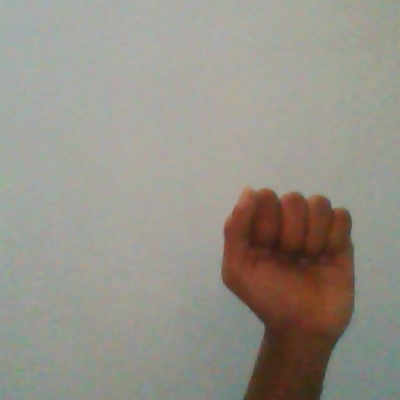

In [ ]:
from IPython.display import Image
Image(filename='ASL_Dataset/Train/A/1066.jpg', width=500)

**Parte 2. Pre Procesamiento de Datos**

---

*Antes de usar las imágenes, se hace un pre procesamiento con el fin de obtener mejores resultados y funcione más adecuadamente. En primera instancia se reescalan los valores de RGB que van de 0 a 255, para pasarlos de 0 a 1; además de transformar algunas imágenes para que salgan en el lado opuesto (efecto espejo), cubriendo la posibilidad de que se usen la mano izquierda o derecha. Por otro lado se aplican otros efectos para cubrir las posibles inclinaciones de las manos y el acercamiento o alejamiento de estas. Finalmente, se hace un ajuste en el tamaño de las imágenes, volviéndolas de 150 x 150 pixeles.*

In [ ]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from time import time
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt1
import matplotlib.pyplot as plt2
import numpy as np

In [ ]:
#Pre procesado de imagenes
setEntrenamiento = ImageDataGenerator(rescale = 1./255,
                                      horizontal_flip = True,
                                      shear_range=0.3,
                                      zoom_range = 0.3)
setPrueba = ImageDataGenerator(rescale = 1./255)
Data_Entrenamiento = setEntrenamiento.flow_from_directory('ASL_Dataset/Train/',
                                        target_size = (150, 150),
                                        batch_size = 32,
                                        class_mode = 'categorical'
                                        )


Data_Prueba = setPrueba.flow_from_directory('ASL_Dataset/Test/',
                                    target_size = (150, 150),
                                    batch_size = 32,
                                    class_mode = 'categorical',                                    )

if Data_Entrenamiento.class_indices == Data_Prueba.class_indices:
    print(Data_Entrenamiento.class_indices)

Found 165670 images belonging to 28 classes.
Found 112 images belonging to 28 classes.
{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'Nothing': 14, 'O': 15, 'P': 16, 'Q': 17, 'R': 18, 'S': 19, 'Space': 20, 'T': 21, 'U': 22, 'V': 23, 'W': 24, 'X': 25, 'Y': 26, 'Z': 27}


**Parte 3. Modelo de Redes Convolucionales**

---
*En esta parte se desarrolla la red convolucional del modelo. Para el desarrollo de esta se usa el Dropout para evitar el sobre ajuste mediante desactivación de una parte de las neuronas, y el Maxpooling que genera los datos mas altos de una región como dato para la siguiente capa.*

In [ ]:
import tensorflow as tf
from time import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
def conv_modelo(num_classes, img_size=150, num_capas=1,multip=1):
    tf.keras.backend.clear_session()
    print ("using",num_classes,"classes")

    inputs = tf.keras.Input(shape=(img_size,img_size,3), name="input_1")
    layers = tf.keras.layers.Conv2D(32*multip,(7,7), activation="relu")(inputs)
    layers = tf.keras.layers.MaxPool2D((2,2))(layers)
    if num_capas==2:
      layers = tf.keras.layers.Conv2D(64*multip,(5,5), activation="relu")(layers)
      layers = tf.keras.layers.MaxPool2D((2,2))(layers)
    if num_capas==3:
      layers = tf.keras.layers.Conv2D(64*multip,(5,5), activation="relu")(layers)
      layers = tf.keras.layers.MaxPool2D((2,2))(layers)
      layers = tf.keras.layers.Conv2D(128*multip,(3,3), activation="relu")(layers)
      layers = tf.keras.layers.Dropout(0.3)(layers)
      layers = tf.keras.layers.MaxPool2D((2,2))(layers)
    layers = tf.keras.layers.Flatten()(layers)
    layers = tf.keras.layers.Dense(512*multip, activation=tf.nn.relu)(layers)
    layers = tf.keras.layers.Dropout(0.3)(layers)
    predictions = tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax, name="output_1")(layers)
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
num_classes=len(Data_Prueba.class_indices)
model = conv_modelo(num_classes)
model.summary()

using 28 classes
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 144, 144, 32)      4736      
                                                                 
 max_pooling2d (MaxPooling2  (None, 72, 72, 32)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 165888)            0         
                                                                 
 dense (Dense)               (None, 512)               84935168  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                            

In [ ]:
model1 = conv_modelo(num_classes,multip=0.5)
model1.summary()

using 28 classes
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 144, 144, 16)      2368      
                                                                 
 max_pooling2d (MaxPooling2  (None, 72, 72, 16)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 82944)             0         
                                                                 
 dense (Dense)               (None, 256)               21233920  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                            

In [ ]:
model2 = conv_modelo(num_classes,num_capas=2)
model2.summary()

using 28 classes
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 144, 144, 32)      4736      
                                                                 
 max_pooling2d (MaxPooling2  (None, 72, 72, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 68, 68, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 34, 34, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 73984)  

In [ ]:
model3 = conv_modelo(num_classes,num_capas=2,multip=0.5)
model3.summary()

using 28 classes
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 144, 144, 16)      2368      
                                                                 
 max_pooling2d (MaxPooling2  (None, 72, 72, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 68, 68, 32)        12832     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 34, 34, 32)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 36992)  

In [ ]:
model4 = conv_modelo(num_classes,num_capas=3)
model4.summary()

using 28 classes
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 144, 144, 32)      4736      
                                                                 
 max_pooling2d (MaxPooling2  (None, 72, 72, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 68, 68, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 34, 34, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 

In [ ]:
model5 = conv_modelo(num_classes,num_capas=3,multip=0.5)
model5.summary()

using 28 classes
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 144, 144, 16)      2368      
                                                                 
 max_pooling2d (MaxPooling2  (None, 72, 72, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 68, 68, 32)        12832     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 34, 34, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 

In [ ]:
model.fit(Data_Entrenamiento,
          batch_size = 32,
          steps_per_epoch = 32,
          epochs = 25,
          validation_data = Data_Prueba,
          validation_steps = 2,
          verbose = 2)


Epoch 1/25
32/32 - 10s - loss: 8.3813 - accuracy: 0.0342 - val_loss: 3.3322 - val_accuracy: 0.0312 - 10s/epoch - 298ms/step
Epoch 2/25
32/32 - 8s - loss: 3.3322 - accuracy: 0.0420 - val_loss: 3.3315 - val_accuracy: 0.0312 - 8s/epoch - 244ms/step
Epoch 3/25
32/32 - 7s - loss: 3.3322 - accuracy: 0.0381 - val_loss: 3.3337 - val_accuracy: 0.0156 - 7s/epoch - 212ms/step
Epoch 4/25
32/32 - 8s - loss: 3.3315 - accuracy: 0.0352 - val_loss: 3.3314 - val_accuracy: 0.0312 - 8s/epoch - 247ms/step
Epoch 5/25
32/32 - 7s - loss: 3.3317 - accuracy: 0.0312 - val_loss: 3.3357 - val_accuracy: 0.0156 - 7s/epoch - 231ms/step
Epoch 6/25
32/32 - 7s - loss: 3.3318 - accuracy: 0.0371 - val_loss: 3.3297 - val_accuracy: 0.0625 - 7s/epoch - 210ms/step
Epoch 7/25
32/32 - 7s - loss: 3.3307 - accuracy: 0.0400 - val_loss: 3.3329 - val_accuracy: 0.0625 - 7s/epoch - 210ms/step
Epoch 8/25
32/32 - 8s - loss: 3.3317 - accuracy: 0.0439 - val_loss: 3.3380 - val_accuracy: 0.0312 - 8s/epoch - 237ms/step
Epoch 9/25
32/32 - 8s 

In [ ]:
model1.fit(Data_Entrenamiento,
          batch_size = 32,
          steps_per_epoch = 32,
          epochs = 25,
          validation_data = Data_Prueba,
          validation_steps = 2,
          verbose = 2)

Epoch 1/25
32/32 - 8s - loss: 6.2231 - accuracy: 0.0420 - val_loss: 3.3321 - val_accuracy: 0.0781 - 8s/epoch - 260ms/step
Epoch 2/25
32/32 - 8s - loss: 3.3322 - accuracy: 0.0332 - val_loss: 3.3323 - val_accuracy: 0.0625 - 8s/epoch - 243ms/step
Epoch 3/25
32/32 - 7s - loss: 3.3316 - accuracy: 0.0508 - val_loss: 3.3322 - val_accuracy: 0.0156 - 7s/epoch - 216ms/step
Epoch 4/25
32/32 - 6s - loss: 3.3325 - accuracy: 0.0391 - val_loss: 3.3322 - val_accuracy: 0.0312 - 6s/epoch - 201ms/step
Epoch 5/25
32/32 - 7s - loss: 3.3313 - accuracy: 0.0391 - val_loss: 3.3308 - val_accuracy: 0.0625 - 7s/epoch - 206ms/step
Epoch 6/25
32/32 - 8s - loss: 3.3324 - accuracy: 0.0244 - val_loss: 3.3311 - val_accuracy: 0.0156 - 8s/epoch - 241ms/step
Epoch 7/25
32/32 - 7s - loss: 3.2867 - accuracy: 0.0645 - val_loss: 3.1587 - val_accuracy: 0.0312 - 7s/epoch - 218ms/step
Epoch 8/25
32/32 - 7s - loss: 3.1829 - accuracy: 0.1045 - val_loss: 2.9571 - val_accuracy: 0.1562 - 7s/epoch - 221ms/step
Epoch 9/25
32/32 - 8s - 

In [ ]:
model2.fit(Data_Entrenamiento,
          batch_size = 32,
          steps_per_epoch = 32,
          epochs = 25,
          validation_data = Data_Prueba,
          validation_steps = 2,
          verbose = 2)

Epoch 1/25
32/32 - 9s - loss: 3.6195 - accuracy: 0.0527 - val_loss: 3.3415 - val_accuracy: 0.0312 - 9s/epoch - 292ms/step
Epoch 2/25
32/32 - 7s - loss: 3.3307 - accuracy: 0.0400 - val_loss: 3.3294 - val_accuracy: 0.1094 - 7s/epoch - 210ms/step
Epoch 3/25
32/32 - 7s - loss: 3.3401 - accuracy: 0.0410 - val_loss: 3.3226 - val_accuracy: 0.0625 - 7s/epoch - 209ms/step
Epoch 4/25
32/32 - 7s - loss: 3.2973 - accuracy: 0.0508 - val_loss: 3.2426 - val_accuracy: 0.2188 - 7s/epoch - 231ms/step
Epoch 5/25
32/32 - 8s - loss: 3.1670 - accuracy: 0.0928 - val_loss: 2.9578 - val_accuracy: 0.2188 - 8s/epoch - 245ms/step
Epoch 6/25
32/32 - 7s - loss: 2.9944 - accuracy: 0.1582 - val_loss: 2.5685 - val_accuracy: 0.3125 - 7s/epoch - 226ms/step
Epoch 7/25
32/32 - 7s - loss: 2.7816 - accuracy: 0.2344 - val_loss: 2.1787 - val_accuracy: 0.4062 - 7s/epoch - 210ms/step
Epoch 8/25
32/32 - 7s - loss: 2.7384 - accuracy: 0.2500 - val_loss: 2.0158 - val_accuracy: 0.4844 - 7s/epoch - 210ms/step
Epoch 9/25
32/32 - 8s - 

In [ ]:
model3.fit(Data_Entrenamiento,
          batch_size = 32,
          steps_per_epoch = 32,
          epochs = 25,
          validation_data = Data_Prueba,
          validation_steps = 2,
          verbose = 2)

Epoch 1/25
32/32 - 8s - loss: 3.4197 - accuracy: 0.0332 - val_loss: 3.3319 - val_accuracy: 0.0312 - 8s/epoch - 263ms/step
Epoch 2/25
32/32 - 8s - loss: 3.3371 - accuracy: 0.0527 - val_loss: 3.3183 - val_accuracy: 0.0781 - 8s/epoch - 240ms/step
Epoch 3/25
32/32 - 7s - loss: 3.3323 - accuracy: 0.0332 - val_loss: 3.3329 - val_accuracy: 0.0469 - 7s/epoch - 226ms/step
Epoch 4/25
32/32 - 7s - loss: 3.3322 - accuracy: 0.0254 - val_loss: 3.3320 - val_accuracy: 0.0156 - 7s/epoch - 203ms/step
Epoch 5/25
32/32 - 7s - loss: 3.3306 - accuracy: 0.0479 - val_loss: 3.3190 - val_accuracy: 0.1719 - 7s/epoch - 205ms/step
Epoch 6/25
32/32 - 8s - loss: 3.3361 - accuracy: 0.0596 - val_loss: 3.3031 - val_accuracy: 0.1250 - 8s/epoch - 244ms/step
Epoch 7/25
32/32 - 7s - loss: 3.1987 - accuracy: 0.0938 - val_loss: 2.6678 - val_accuracy: 0.2500 - 7s/epoch - 205ms/step
Epoch 8/25
32/32 - 6s - loss: 2.9247 - accuracy: 0.1709 - val_loss: 2.2825 - val_accuracy: 0.2344 - 6s/epoch - 201ms/step
Epoch 9/25
32/32 - 7s - 

In [ ]:
model4.fit(Data_Entrenamiento,
          batch_size = 32,
          steps_per_epoch = 32,
          epochs = 25,
          validation_data = Data_Prueba,
          validation_steps = 2,
          verbose = 2)

Epoch 1/25
32/32 - 10s - loss: 3.3965 - accuracy: 0.0449 - val_loss: 3.2559 - val_accuracy: 0.0938 - 10s/epoch - 308ms/step
Epoch 2/25
32/32 - 8s - loss: 3.1077 - accuracy: 0.1270 - val_loss: 2.7946 - val_accuracy: 0.1406 - 8s/epoch - 252ms/step
Epoch 3/25
32/32 - 7s - loss: 2.8960 - accuracy: 0.1631 - val_loss: 2.5786 - val_accuracy: 0.3594 - 7s/epoch - 215ms/step
Epoch 4/25
32/32 - 8s - loss: 2.7041 - accuracy: 0.2129 - val_loss: 2.2800 - val_accuracy: 0.3438 - 8s/epoch - 250ms/step
Epoch 5/25
32/32 - 7s - loss: 2.5292 - accuracy: 0.2539 - val_loss: 2.0906 - val_accuracy: 0.3906 - 7s/epoch - 216ms/step
Epoch 6/25
32/32 - 8s - loss: 2.2068 - accuracy: 0.3369 - val_loss: 1.5218 - val_accuracy: 0.6875 - 8s/epoch - 243ms/step
Epoch 7/25
32/32 - 9s - loss: 1.8923 - accuracy: 0.4150 - val_loss: 1.6892 - val_accuracy: 0.5469 - 9s/epoch - 275ms/step
Epoch 8/25
32/32 - 8s - loss: 1.6771 - accuracy: 0.4805 - val_loss: 1.0933 - val_accuracy: 0.6562 - 8s/epoch - 236ms/step
Epoch 9/25
32/32 - 9s 

In [ ]:
model5.fit(Data_Entrenamiento,
          batch_size = 32,
          steps_per_epoch = 32,
          epochs = 25,
          validation_data = Data_Prueba,
          validation_steps = 2,
          verbose = 2)

Epoch 1/25
32/32 - 7s - loss: 3.3316 - accuracy: 0.0352 - val_loss: 3.3346 - val_accuracy: 0.0156 - 7s/epoch - 211ms/step
Epoch 2/25
32/32 - 8s - loss: 3.3332 - accuracy: 0.0351 - val_loss: 3.3325 - val_accuracy: 0.0469 - 8s/epoch - 241ms/step
Epoch 3/25
32/32 - 7s - loss: 3.3324 - accuracy: 0.0371 - val_loss: 3.3309 - val_accuracy: 0.0469 - 7s/epoch - 207ms/step
Epoch 4/25
32/32 - 7s - loss: 3.3305 - accuracy: 0.0449 - val_loss: 3.3271 - val_accuracy: 0.0469 - 7s/epoch - 204ms/step
Epoch 5/25
32/32 - 8s - loss: 3.3319 - accuracy: 0.0479 - val_loss: 3.3324 - val_accuracy: 0.0312 - 8s/epoch - 247ms/step
Epoch 6/25
32/32 - 8s - loss: 3.3288 - accuracy: 0.0332 - val_loss: 3.3396 - val_accuracy: 0.0469 - 8s/epoch - 242ms/step
Epoch 7/25
32/32 - 7s - loss: 3.3323 - accuracy: 0.0371 - val_loss: 3.3353 - val_accuracy: 0.0312 - 7s/epoch - 208ms/step
Epoch 8/25
32/32 - 8s - loss: 3.3330 - accuracy: 0.0371 - val_loss: 3.3327 - val_accuracy: 0.0469 - 8s/epoch - 245ms/step
Epoch 9/25
32/32 - 7s - 

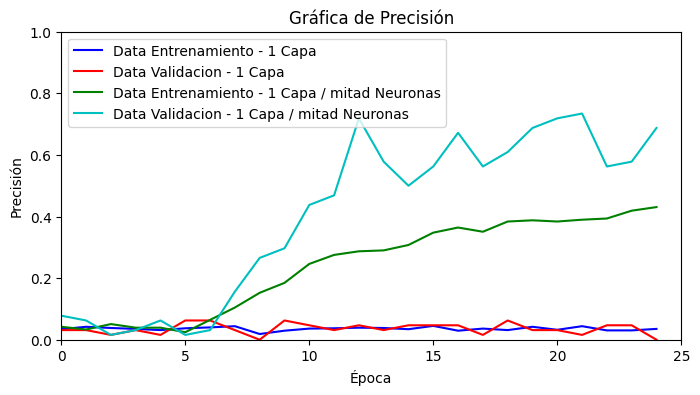

In [ ]:
# save model training history into several variables
acc = model.history.history['accuracy']
valAcc = model.history.history['val_accuracy']
epoch = model.history.epoch
acc1 = model1.history.history['accuracy']
valAcc1 = model1.history.history['val_accuracy']
epoch1 = model1.history.epoch
acc2 = model2.history.history['accuracy']
valAcc2 = model2.history.history['val_accuracy']
epoch2 = model2.history.epoch
acc3 = model3.history.history['accuracy']
valAcc3 = model3.history.history['val_accuracy']
epoch3 = model3.history.epoch
acc4 = model4.history.history['accuracy']
valAcc4 = model4.history.history['val_accuracy']
epoch4 = model4.history.epoch
acc5 = model5.history.history['accuracy']
valAcc5 = model5.history.history['val_accuracy']
epoch5 = model5.history.epoch


plt.subplots(figsize=(8, 4))
plt.plot(epoch, acc, label = 'Data Entrenamiento - 1 Capa', color = 'b')
plt.plot(epoch, valAcc, label = 'Data Validacion - 1 Capa', color = 'r')
plt.plot(epoch1, acc1, label = 'Data Entrenamiento - 1 Capa / mitad Neuronas', color = 'g')
plt.plot(epoch1, valAcc1, label = 'Data Validacion - 1 Capa / mitad Neuronas', color = 'c')

plt.xlabel('Época')
plt.ylabel('Precisión')
plt.xlim([0, len(epoch)])
plt.ylim([0, 1])
plt.title('Gráfica de Precisión')
plt.legend()
plt.show()


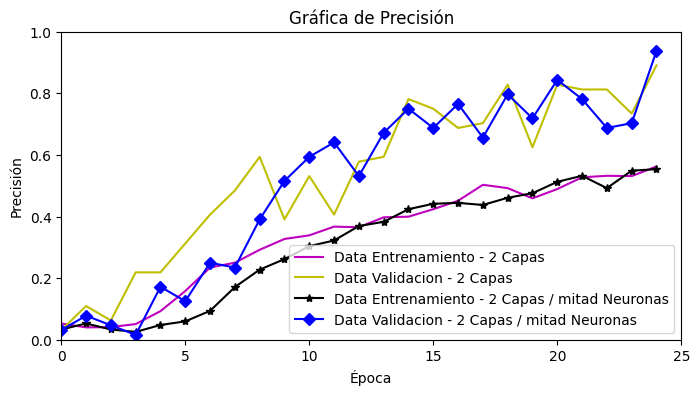

In [ ]:
plt.subplots(figsize=(8, 4))
plt.plot(epoch2, acc2, label = 'Data Entrenamiento - 2 Capas', color = 'm')
plt.plot(epoch2, valAcc2, label = 'Data Validacion - 2 Capas', color = 'y')
plt.plot(epoch3, acc3, label = 'Data Entrenamiento - 2 Capas / mitad Neuronas', color = 'k', marker = '*')
plt.plot(epoch3, valAcc3, label = 'Data Validacion - 2 Capas / mitad Neuronas', color = 'b', marker = 'D')

plt.xlabel('Época')
plt.ylabel('Precisión')
plt.xlim([0, len(epoch)])
plt.ylim([0, 1])
plt.title('Gráfica de Precisión')
plt.legend()
plt.show()

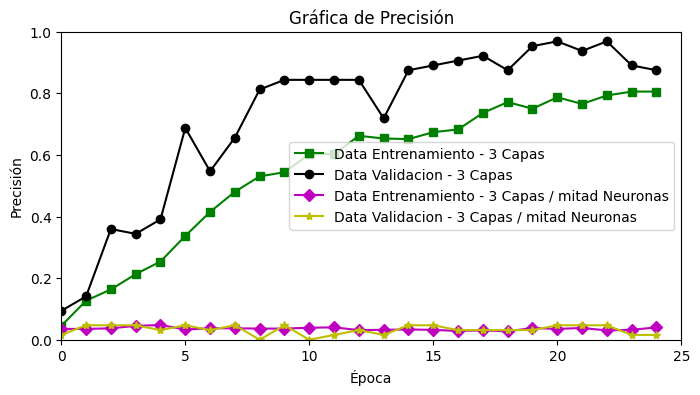

In [ ]:
plt.subplots(figsize=(8, 4))
plt.plot(epoch4, acc4, label = 'Data Entrenamiento - 3 Capas', color = 'g', marker = 's')
plt.plot(epoch4, valAcc4, label = 'Data Validacion - 3 Capas', color = 'k', marker = 'o')
plt.plot(epoch5, acc5, label = 'Data Entrenamiento - 3 Capas / mitad Neuronas', color = 'm', marker = 'D')
plt.plot(epoch5, valAcc5, label = 'Data Validacion - 3 Capas / mitad Neuronas', color = 'y', marker = '*')


plt.xlabel('Época')
plt.ylabel('Precisión')
plt.xlim([0, len(epoch)])
plt.ylim([0, 1])
plt.title('Gráfica de Precisión')
plt.legend()
plt.show()

In [ ]:
!pip install Keras-Preprocessing
from keras_preprocessing import image


In [ ]:
import os
y_pred = []
y_pred1 = []
y_pred2 = []
y_pred3 = []
y_pred4 = []
y_pred5 = []
for i in Data_Prueba.class_indices:
    # take the path of data test
    labelTest = 'ASL_Dataset/Test/'+i+'/'
    for j in os.listdir(labelTest):
        # save the label
        x_pred = labelTest + j

        # load image into matrix
        img = image.load_img(x_pred, target_size = (150, 150))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis = 0)
        matxImg = np.vstack([x])


        predict = model.predict(matxImg, batch_size = 32)
        predict = np.argmax(predict, axis = 1)
        y_pred.append(predict[0])
        predict1 = model1.predict(matxImg, batch_size = 32)
        predict1 = np.argmax(predict1, axis = 1)
        y_pred1.append(predict1[0])
        predict2 = model2.predict(matxImg, batch_size = 32)
        predict2 = np.argmax(predict2, axis = 1)
        y_pred2.append(predict2[0])
        predict3 = model3.predict(matxImg, batch_size = 32)
        predict3 = np.argmax(predict3, axis = 1)
        y_pred3.append(predict3[0])
        predict4 = model4.predict(matxImg, batch_size = 32)
        predict4 = np.argmax(predict4, axis = 1)
        y_pred4.append(predict4[0])
        predict5 = model5.predict(matxImg, batch_size = 32)
        predict5 = np.argmax(predict5, axis = 1)
        y_pred5.append(predict5[0])

1/1 [==============================] - 0s 16ms/step


Text(0.5, 1.0, 'Matriz Confusión - Modelo 3 Capas - Mitad Neu.')

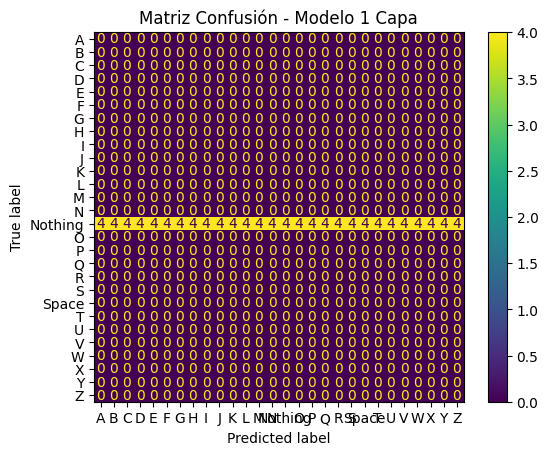

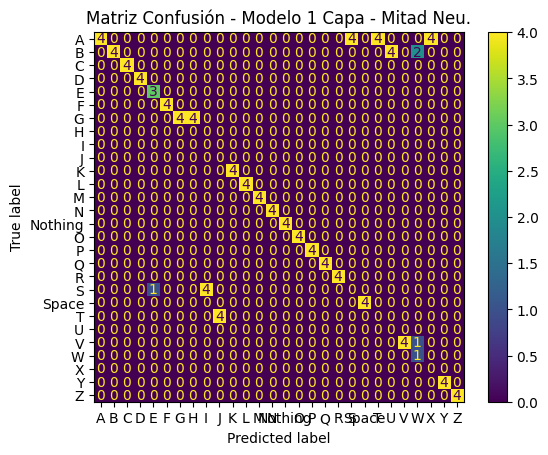

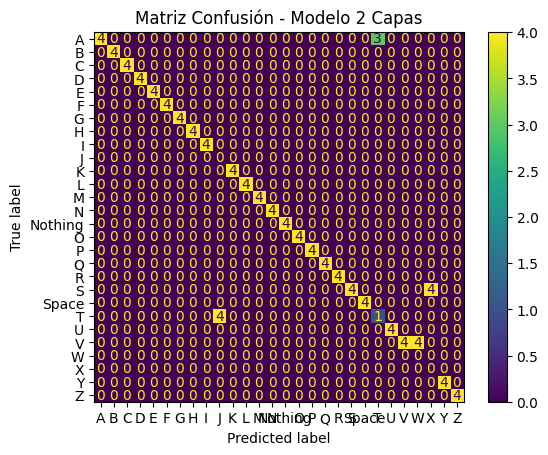

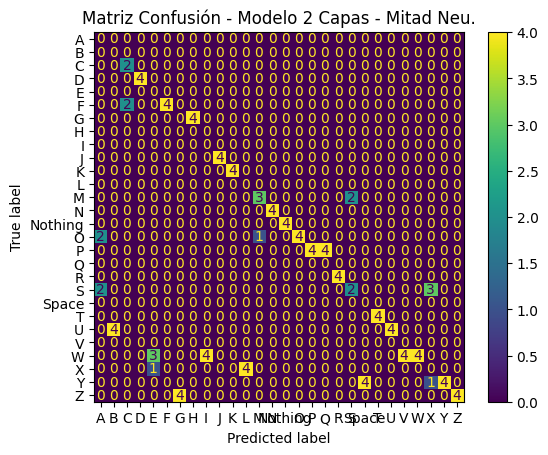

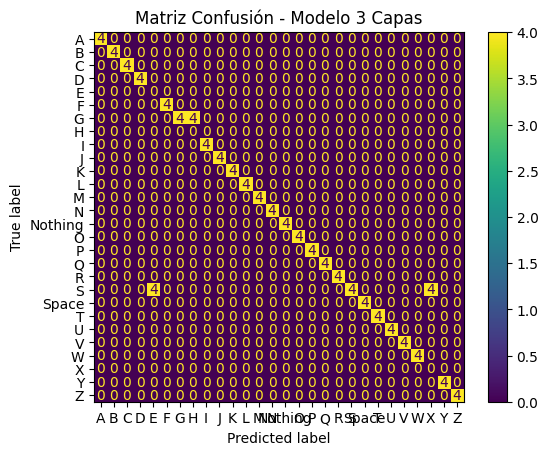

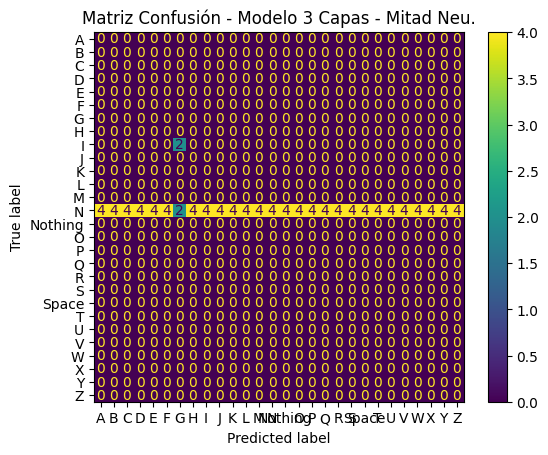

In [ ]:
from sklearn.metrics import (accuracy_score,
                             confusion_matrix,
                             ConfusionMatrixDisplay)
ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_pred, Data_Prueba.classes,
                          labels = list(Data_Prueba.class_indices.values())),
                       display_labels = list(Data_Prueba.class_indices.keys())).plot()
plt.title('Matriz Confusión - Modelo 1 Capa')

ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_pred1, Data_Prueba.classes,
                          labels = list(Data_Prueba.class_indices.values())),
                       display_labels = list(Data_Prueba.class_indices.keys())).plot()
plt.title('Matriz Confusión - Modelo 1 Capa - Mitad Neu.')

ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_pred2, Data_Prueba.classes,
                          labels = list(Data_Prueba.class_indices.values())),
                       display_labels = list(Data_Prueba.class_indices.keys())).plot()
plt.title('Matriz Confusión - Modelo 2 Capas')

ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_pred3, Data_Prueba.classes,
                          labels = list(Data_Prueba.class_indices.values())),
                       display_labels = list(Data_Prueba.class_indices.keys())).plot()
plt.title('Matriz Confusión - Modelo 2 Capas - Mitad Neu.')

ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_pred4, Data_Prueba.classes,
                          labels = list(Data_Prueba.class_indices.values())),
                       display_labels = list(Data_Prueba.class_indices.keys())).plot()
plt.title('Matriz Confusión - Modelo 3 Capas')

ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_pred5, Data_Prueba.classes,
                          labels = list(Data_Prueba.class_indices.values())),
                       display_labels = list(Data_Prueba.class_indices.keys())).plot()
plt.title('Matriz Confusión - Modelo 3 Capas - Mitad Neu.')

In [ ]:
from tensorflow.keras.models import load_model
model4.save('/content/drive/MyDrive/Modelos/modeloCNNAlfabeto.hdf5')
model4.save_weights('/content/drive/MyDrive/Modelos/PesosCNNAlfabeto.hdf5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
